### kaggle dataset

In [ ]:
!pip -q install kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("kaggle API configured")

✅ Kaggle API configured successfully!


In [ ]:
import os

if not os.path.exists('Images'):
    os.makedirs('Images')

In [ ]:
!kaggle datasets download -d mehaksingal/illegible-medical-prescription-images-dataset

!unzip -q illegible-medical-prescription-images-dataset.zip -d ./Images/invalid


Dataset URL: https://www.kaggle.com/datasets/mehaksingal/illegible-medical-prescription-images-dataset
License(s): MIT
illegible-medical-prescription-images-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
📂 Dataset downloaded and unzipped into the /content/ directory.


In [ ]:
!kaggle datasets download -d dikshaasinghhh/bajaj

!unzip -q bajaj.zip -d ./Images/valid


Dataset URL: https://www.kaggle.com/datasets/dikshaasinghhh/bajaj
License(s): unknown
bajaj.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import os
from PIL import Image

DATA_DIR = './Images'

for root, _, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith('.jpg'):
            jpg_path = os.path.join(root, file)
            png_path = os.path.join(root, os.path.splitext(file)[0] + '.png')
            try:
                with Image.open(jpg_path) as img:
                    img.save(png_path)
                os.remove(jpg_path)
            except Exception as e:
                print(f"Could not convert {jpg_path}: {e}")

print("Conversion complete.")

Conversion complete.


### data preparation

**for creating robust invalid data gaussian blur and motion blur were added
to valid images**

In [ ]:
import cv2
import numpy as np
import os
import random
IMG_SIZE = 456

VALID_PRESCRIPTION_DIR = '/content/Images/valid_images'
INVALID_PRESCRIPTION_DIR = '/content/Images/invalid_images'

NUM_IMAGES_TO_CREATE = 320

valid_images = [f for f in os.listdir(VALID_PRESCRIPTION_DIR) if f.endswith(('.jpg', '.png', '.jpeg'))]

for i in range(NUM_IMAGES_TO_CREATE):
    image_name = random.choice(valid_images)
    image_path = os.path.join(VALID_PRESCRIPTION_DIR, image_name)
    img = cv2.imread(image_path)
    if img is None: continue

    augmentation_choice = random.randint(1, 2)
    if augmentation_choice == 1:
        blur_intensity = random.randrange(15, 45, 2)
        augmented_img = cv2.GaussianBlur(img, (blur_intensity, blur_intensity), 0)
        prefix = 'gauss_blur_'
    elif augmentation_choice == 2:
        kernel_size = random.randint(15, 40)
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
        kernel = kernel / kernel_size
        augmented_img = cv2.filter2D(img, -1, kernel)
        prefix = 'motion_blur_'


    new_image_name = f"{prefix}{i+1}_{image_name}"
    output_path = os.path.join(INVALID_PRESCRIPTION_DIR, new_image_name)
    cv2.imwrite(output_path, augmented_img)

print(f"created and added {NUM_IMAGES_TO_CREATE} new images to the 'invalid' folder.")

Successfully created and added 320 new images to the 'invalid' folder.


### model preparation

In [ ]:
import tensorflow as tf

IMG_SIZE = 456
BATCH_SIZE = 16
DATA_DIR = '/content/Images'

print("Loading and preprocessing datasets...")
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Building the EfficientNet-B5 model")

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base_model = tf.keras.applications.EfficientNetB5(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x = base_model(inputs, training=False)


x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Loading and preprocessing datasets...
Found 1195 files belonging to 2 classes.
Using 956 files for training.
Using 239 files for validation.
Building the EfficientNet-B5 model


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 456, 456, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb5 (Functional)     │ (None, 15, 15, 2048)   │    28,513,527 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,515,576 (108.78 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 28,513,527 (108.77 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    # initial_epoch=history.epoch[-1]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.6922 - loss: 0.5502 - val_accuracy: 0.9079 - val_loss: 0.3386
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 286ms/step - accuracy: 0.9005 - loss: 0.3272 - val_accuracy: 0.9331 - val_loss: 0.2582
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.9232 - loss: 0.2623 - val_accuracy: 0.9372 - val_loss: 0.2138
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 292ms/step - accuracy: 0.9545 - loss: 0.2131 - val_accuracy: 0.9456 - val_loss: 0.1871
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.9540 - loss: 0.1806 - val_accuracy: 0.9456 - val_loss: 0.1699
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 293ms/step - accuracy: 0.9511 - loss: 0.1748 - val_accuracy: 0.9456 - val_loss: 0.1541
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 292ms/step - accuracy: 0.9656 - loss: 0.1536 - val_accuracy: 0.9540 - val_loss: 0.1439
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 293ms/step - accuracy: 0.9617 - loss: 0.1447 - val_accura

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy:.2%}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.9658 - loss: 0.1110
Validation Accuracy: 95.82%


In [ ]:
import numpy as np
from sklearn.metrics import classification_report

val_predictions = model.predict(val_ds)

val_pred_labels = (val_predictions > 0.5).astype(int)

val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)
print(classification_report(val_true_labels, val_pred_labels, target_names=['invalid', 'valid']))

15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step
              precision    recall  f1-score   support

     invalid       0.99      0.95      0.97       164
       valid       0.90      0.97      0.94        75

    accuracy                           0.96       239
   macro avg       0.94      0.96      0.95       239
weighted avg       0.96      0.96      0.96       239



Shape of a batch of images: (16, 456, 456, 3)
Shape of a batch of labels: (16, 1)


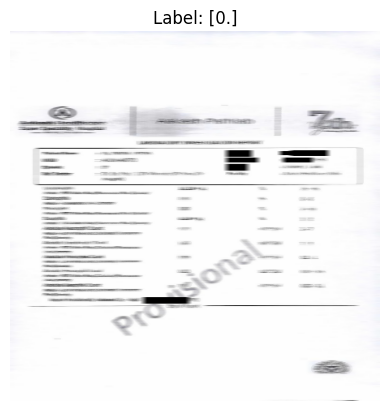

In [ ]:
for images, labels in val_ds.take(1):
    print("Shape of a batch of images:", images.shape)
    print("Shape of a batch of labels:", labels.shape)
    # You can optionally display an image, for example the first one in the batch
    import matplotlib.pyplot as plt
    plt.imshow(images[-3].numpy().astype("uint8"))
    plt.title(f"Label: {labels[-3].numpy()}")
    plt.axis("off")
    plt.show()

    #label : 0 invalid
    #label : 1 valid

In [ ]:
def predict_prescription_validity(image_path):
    IMG_SIZE = 456
    img = tf.keras.utils.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    prediction = model.predict(img_array)
    score = prediction[0][0]

    if score < 0.5:
        print(f"This prescription is likely INVALID with {100 * (1 - score):.2f}% confidence.")
    else:
        print(f"This prescription is likely VALID with {100 * score:.2f}% confidence.")

predict_prescription_validity('/content/Images/invalid_images/1.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
This prescription is likely INVALID with 81.58% confidence.


In [ ]:
predict_prescription_validity('/content/BLR-0425-PA-0036693_ARVIND REDDY REPALA 0036693_28-04-2025_1120-45_AM@E.pdf_page_24.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
This prescription is likely VALID with 95.25% confidence.


In [ ]:
model.save('model_EfficientNet.keras')